In [113]:
from Bio import AlignIO, SeqIO
from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio import codonalign
from Bio.Alphabet import generic_dna, Gapped, IUPAC
from skbio.stats.distance import DistanceMatrix
from Bio.Data.CodonTable import generic_by_id
from Bio.Alphabet import Gapped,IUPAC
from Bio.codonalign.codonalphabet import get_codon_alphabet
from Bio.codonalign.codonseq import cal_dn_ds
import pandas as pd
import itertools
# %load_ext rpy2.ipython
path_to_files='../mauve_alignments/fna/'
path_out="/home/maeperez/projects/def-bacc/maeperez/Clams/VesicSymb_Evolution/dowstream_analyses_and_data/"


In [122]:
### Get list of genes to concat
with open(path_to_files+'filelist_nopseudo_638','r') as f:
    lines=[file[8:-4] for file in f.read().splitlines()]
print(len(lines))

with open(path_out+'core_genes_with_recomb_AICc.txt','r') as f:
    recomb=[file for file in f.read().splitlines()]
    
print(len(recomb))
print(recomb[:3])
lines=[line for line in lines if line not in recomb]
print(len(lines))
print(lines[:5])

638
143
['Rmag_0007', 'Rmag_0009', 'Rmag_0011']
495
['Rmag_0001', 'Rmag_0002', 'Rmag_0003', 'Rmag_0005', 'Rmag_0006']


In [123]:
#### Concatenate core genes for symb and mito

dic_sym={}
for gene in [lines[0]]:
    cat_aln_symb=AlignIO.read(path_to_files+'aligned_'+gene+'.fna','fasta')
    for i in range(len(cat_aln_symb)):
        cat_aln_symb[i].id=cat_aln_symb[i].id.split('|')[0]
        dic_sym[i]=cat_aln_symb[i].id
    
for gene in lines[1:]:
    new_aln=AlignIO.read(path_to_files+'aligned_'+gene+'.fna','fasta')
    for i in range(len(cat_aln_symb)):
        new_aln[i].id=new_aln[i].id.split('|')[0]
    cat_aln_symb+=new_aln
print(cat_aln_symb)

dic_sym[0]='X.Bathy'
dic_sym[8]='X.SUP05'

for k,v in dic_sym.items():
    dic_sym[k]=v.split('.')[1] 
print(dic_sym) 

with open(path_to_files+'filelist_withpseudo_702-716','r') as f:
    lines=[file[:-4] for file in f.read().splitlines()]
print(len(lines))

dic_mito={}
for gene in [lines[702]]:
    cat_aln_mito=AlignIO.read(path_to_files+gene+'.fna','fasta')
    for i in range(len(cat_aln_mito)):
        cat_aln_mito[i].id=cat_aln_mito[i].id.split('|')[0]
        dic_mito[i]=cat_aln_mito[i].id
    
for gene in lines[703:-1]:
    new_aln=AlignIO.read(path_to_files+gene+'.fna','fasta')
    for i in range(len(cat_aln_mito)):
        new_aln[i].id=new_aln[i].id.split('|')[0]
    cat_aln_mito+=new_aln
print(cat_aln_mito)

dic_mito[10]='C.marissinica'
dic_mito[11]='C.fausta'

for k,v in dic_mito.items():
    dic_mito[k]=v.split('.')[1]    
dic_mito[13]='okutanii'



SingleLetterAlphabet() alignment with 17 rows and 484320 columns
ATGCCAACAACTTGGGAAAAATGCCTTGAAACTTTGAAAGATAC...GGT Bathy
ATGTCGCAAATCTGGTCAGAATGTTTAAACACTCTTAGAGACAG...GGT R.fausta
ATGTCACAAACTTGGTCACAATGTTTAAACACTCTTAGAGACAG...GGT R.magnifica
ATGTCGAAAATTTGGTCACAATGTTTAAACACGCTTAGAAACAG...GGT R.pacifica
ATGTCGCAAACTTGGTCACAATGTTTAAACACACTTAGAGACAA...GGT R.phaseoliformis
ATGTCGCAAACTTGGTCACAATGTTTAAACACACTTAGAGGCAG...GGT R.pliocardia
ATGTCGCAAATCTGGTCAGAATGTTTAAACACTCTTAGAGACAG...GGT R.rectimargo
ATGTCGCAAACTTGGTCACAATGTTTAAACACGCTTAGAGACAA...GGT R.southwardae
ATGTCAAAAACTTGGGCGCAATGTTTAAGCACACTAAAAGACAC...GGT SUP05
ATGTCTCAAACTTGGTCACAATGCCTAAATACTCTTAAAGATAG...AGT V.diagonalis
ATGTCTCAAACTTGGTCACAATGCCTAAATACTCTTAAAGATAG...AGT V.extenta
ATGTCTCAAACTTGGTCACAATGCCTAAACACACTTAGAGATAG...AGT V.gigas1
ATGTCTCAAACTTGGTCACAATGCCTAAACACACTTAGAGATAG...AGT V.gigas2
ATGTCTCAAACTTGGTCACAATGCCTAAACACTCTTAGAGATAG...AGT V.marissinica
ATGTCTCAAACTTGGTCACAATGCCTAAACACACTTAGAGATAG...AGT V.okutanii
ATG

In [132]:
print(set(dic_mito.values()),
    set(dic_sym.values()))

{'diagonalis', 'phaseoliformis_ref', 'rectimargo', 'gigas1', 'phaseoliformis', 'extenta', 'soyoae1', 'soyoae2', 'gigas2', 'pliocardia', 'fausta', 'okutanii', 'southwardae', 'pacifica', 'magnifica', 'mariana_ref', 'marissinica'} {'diagonalis', 'rectimargo', 'Bathy', 'gigas1', 'phaseoliformis', 'extenta', 'soyoae1', 'pliocardia', 'gigas2', 'soyoae2', 'fausta', 'okutanii', 'pacifica', 'southwardae', 'SUP05', 'magnifica', 'marissinica'}


# Distance with method ML

## Mito

In [41]:
### Init codon table

table5=generic_by_id[5]
table5.nucleotide_alphabet=IUPAC.ambiguous_dna
table5.protein_alphabet=IUPAC.extended_protein
print(table5)

table5.forward_table['AAN'] = "K"
table5.forward_table['GAY'] = "D"
table5.forward_table['YTA'] = "L"
table5.forward_table['ATY'] = "I"
table5.forward_table['TCY'] = "S"
table5.forward_table['GTY'] = "V"
table5.forward_table['GGY'] = "G"
table5.forward_table['CCY'] = "P"
table5.forward_table['GGR'] = "G"
table5.forward_table['AYA'] = "X"
table5.forward_table['NTA'] = "X"
table5.forward_table['ANA'] = "X"
table5.forward_table['ATN'] = "X"
table5.forward_table['ANN'] = "X"
table5.forward_table['NNN'] = "X"
table5.forward_table['NNA'] = "X"
table5.forward_table['NNG'] = "X"
table5.forward_table['GNN'] = "X"
table5.forward_table['NTG'] = "X"
table5.forward_table['GGN'] = "G"
table5.forward_table['TCN'] = "S"
t5=get_codon_alphabet(table5, gap_char="-")
t5.letters+=['AAN','GAY','YTA','ATY','TCY','GTY','GGY','CCY','GGR','AYA','NTA','ANA','ATN','ANN','NNN','NNA','NNG','GNN','NTG','GGN','TCN']
print(t5)

### Get core_mitoch

align=cat_aln_mito
codon_aln=codonalign.CodonAlignment.from_msa(align,alphabet=t5)

### get dnds

print(table5)
mat=codon_aln.get_dn_ds_matrix(method="ML",codon_table=table5)
dN=DistanceMatrix(mat[0]).condensed_form()
dS=DistanceMatrix(mat[1]).condensed_form()
dNdS=dN/dS

### Create df

ids=['-'.join(sorted([dic_mito[comb[0]],dic_mito[comb[1]]])) for comb in itertools.combinations(range(len(cat_aln_mito)), 2)]
df_mitoch=pd.DataFrame({'dnds_mito':dNdS,'ds_mito':dS, 'dn_mito': dN}, index=ids)
df_mitoch

Table 5 Invertebrate Mitochondrial, SGC4

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA W   | A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L   | CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I(s)| ACT T   | AAT N   | AGT S   | T
A | ATC I(s)| ACC T   | AAC N   | AGC S   | C
A | ATA M(s)| ACA T   | AAA K   | AGA S   | A
A | ATG M(s)| ACG T   | AAG K   | AGG S   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V(s)| GCG A   | GAG E   | GGG G 

,dnds_mito,ds_mito,dn_mito
diagonalis-gigas1,0.062034,0.497949,0.030890
diagonalis-gigas2,0.055520,0.384686,0.021358
diagonalis-mariana_ref,0.020079,2.615905,0.052525
diagonalis-phaseoliformis_ref,0.030178,1.701903,0.051360
diagonalis-phaseoliformis,0.020351,2.591619,0.052742
...,...,...,...
okutanii-soyoae2,0.054267,0.104049,0.005646
okutanii-pliocardia,0.018379,3.071426,0.056449
soyoae1-soyoae2,5.406876,0.000018,0.000097
pliocardia-soyoae1,0.018104,3.094842,0.056030


## Symbiont

In [42]:
### init codon table

table11=generic_by_id[11]
table11.nucleotide_alphabet=IUPAC.ambiguous_dna
table11.protein_alphabet=IUPAC.extended_protein
print(table11)

t11=get_codon_alphabet(table11, gap_char="-")

### get core_symb

align=cat_aln_symb
codon_aln=codonalign.CodonAlignment.from_msa(align,alphabet=t11)

### get dnds

mat=codon_aln.get_dn_ds_matrix(method="ML",codon_table=table11)
dN=DistanceMatrix(mat[0]).condensed_form()
dS=DistanceMatrix(mat[1]).condensed_form()
dNdS=dN/dS

### Create df
ids=['-'.join(sorted([dic_sym[comb[0]],dic_sym[comb[1]]])) for comb in itertools.combinations(range(len(cat_aln_symb)), 2)]
df_sym=pd.DataFrame({'dnds_symb':dNdS,'ds_symb':dS, 'dn_symb': dN}, index=ids)
df_sym

Table 11 Bacterial, Archaeal, Plant Plastid

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I(s)| ACT T   | AAT N   | AGT S   | T
A | ATC I(s)| ACC T   | AAC N   | AGC S   | C
A | ATA I(s)| ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V(s)| GCG A   | GAG E   | GGG

,dnds_symb,ds_symb,dn_symb
Bathy-fausta,0.065575,2.288715,1.500820e-01
Bathy-magnifica,0.057801,2.704762,1.563392e-01
Bathy-pacifica,0.068299,2.221924,1.517560e-01
Bathy-phaseoliformis,0.068196,2.133869,1.455217e-01
Bathy-pliocardia,0.066236,2.226254,1.474578e-01
...,...,...,...
marissinica-soyoae1,0.110622,0.184296,2.038723e-02
marissinica-soyoae2,0.110443,0.184322,2.035713e-02
okutanii-soyoae1,0.107131,0.087918,9.418766e-03
okutanii-soyoae2,0.106470,0.088021,9.371587e-03


In [52]:
## Merge symb and mitoch tables 

df=pd.merge(df_mitoch,df_sym,how='outer',left_index=True, right_index=True)
df

,dnds_mito,ds_mito,dn_mito,dnds_symb,ds_symb,dn_symb
Bathy-SUP05,NaN,NaN,NaN,0.055494,2.701645,1.499240e-01
Bathy-diagonalis,NaN,NaN,NaN,0.027825,6.088162,1.694018e-01
Bathy-extenta,NaN,NaN,NaN,0.027849,6.085860,1.694838e-01
Bathy-fausta,NaN,NaN,NaN,0.065575,2.288715,1.500820e-01
Bathy-gigas1,NaN,NaN,NaN,0.029509,5.747205,1.695946e-01
...,...,...,...,...,...,...
rectimargo-soyoae1,0.027006,2.240516,0.060506,0.097216,0.839376,8.160042e-02
rectimargo-soyoae2,0.027087,2.234493,0.060526,0.097104,0.839381,8.150734e-02
southwardae-soyoae1,0.029564,1.568854,0.046382,0.094897,0.822741,7.807594e-02
southwardae-soyoae2,0.029175,1.605606,0.046843,0.094809,0.822477,7.797780e-02


In [57]:
## Add info group
print(sorted(list(set(list(dic_mito.values())+list(dic_sym.values())))))

dic_group=dict(zip(sorted(list(set(list(dic_mito.values())+list(dic_sym.values())))),['F','F','V','V','R','V','V','R','V','V','V','R','R','R','R','R','R','V','V']))


df['Groups']=['-'.join(sorted([dic_group[i.split('-')[0]], dic_group[i.split('-')[1]]])) for i in df.index.values]
df

['Bathy', 'SUP05', 'diagonalis', 'extenta', 'fausta', 'gigas1', 'gigas2', 'magnifica', 'mariana_ref', 'marissinica', 'okutanii', 'pacifica', 'phaseoliformis', 'phaseoliformis_ref', 'pliocardia', 'rectimargo', 'southwardae', 'soyoae1', 'soyoae2']


,dnds_mito,ds_mito,dn_mito,dnds_symb,ds_symb,dn_symb,Groups
Bathy-SUP05,NaN,NaN,NaN,0.055494,2.701645,1.499240e-01,F-F
Bathy-diagonalis,NaN,NaN,NaN,0.027825,6.088162,1.694018e-01,F-V
Bathy-extenta,NaN,NaN,NaN,0.027849,6.085860,1.694838e-01,F-V
Bathy-fausta,NaN,NaN,NaN,0.065575,2.288715,1.500820e-01,F-R
Bathy-gigas1,NaN,NaN,NaN,0.029509,5.747205,1.695946e-01,F-V
...,...,...,...,...,...,...,...
rectimargo-soyoae1,0.027006,2.240516,0.060506,0.097216,0.839376,8.160042e-02,R-V
rectimargo-soyoae2,0.027087,2.234493,0.060526,0.097104,0.839381,8.150734e-02,R-V
southwardae-soyoae1,0.029564,1.568854,0.046382,0.094897,0.822741,7.807594e-02,R-V
southwardae-soyoae2,0.029175,1.605606,0.046843,0.094809,0.822477,7.797780e-02,R-V


In [58]:
df.to_csv(path_out+'dsNuclMito_results.txt',header=True,index=True,sep='\t')

Text(0.5, 1.0, 'ds mitoch_vs_nucl')

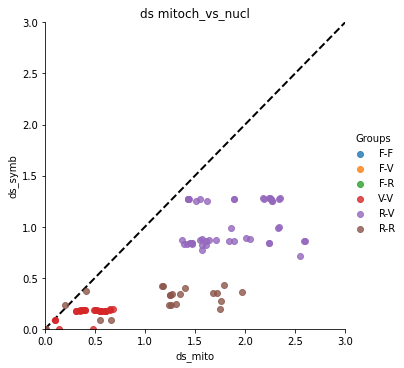

In [92]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(plt)
# Set figure size with matplotlib
# plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.lmplot(x='ds_mito', y='ds_symb',hue='Groups',fit_reg=False,data=df)

# add trend line
xmin,xmax=0,3
ymin,ymax=0,3
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('ds mitoch_vs_nucl')

# Get transitions and transversions for testing saturation

In [23]:


a=SeqRecord(Seq('CT-GTACGT', Gapped(IUPAC.ambiguous_dna)), id="Alpha")
b=SeqRecord(Seq('CGAATGYCN', Gapped(IUPAC.ambiguous_dna)), id="Beta")
c=SeqRecord(Seq('TTTATGNCN', Gapped(IUPAC.ambiguous_dna)), id="Gamma")
test_aln=MultipleSeqAlignment([a,b,c])
dic={0:'Alpha',
    1:'Beta',
    2:'Gamma'}
print(test_aln)

def get_pairwise_tstv_counts(aln,dic):
    from itertools import combinations,permutations
    import pandas as pd
    from collections import Counter
    from itertools import combinations,permutations
    ## get dictionnaries
    alphabet=['A','T','G','C','-','N','Y','R']
    chem={'A':'pur','T':'pyr','G':'pur','C':'pyr','Y':'pyr','R':'pur'}
    trs={}
    for item in permutations(alphabet,2):
        if item[0]==item[1]:
            continue
        elif '-' in item:
            continue
        elif 'N' in item:
            continue
        elif chem[item[0]]==chem[item[1]]:
            trs[item]='transition'
        else:
            trs[item]='transversion'
    
    ## iter through alignment
    ids=['-'.join(sorted([dic[comb[0]],dic[comb[1]]])) for comb in itertools.combinations(range(len(aln)), 2)]
    tstv=pd.DataFrame(0,columns=['transition','transversion'], index=ids)
    for (i,j) in combinations(range(len(aln)),2):
        idx='-'.join(map(str,sorted([dic[i],dic[j]])))
        pair_counts=Counter(zip(aln[i].seq,aln[j].seq))
        for pair in pair_counts.keys():
            if pair not in trs.keys():
                continue
            else:
                tstv[trs[pair]][idx]+=pair_counts[pair]
    return(tstv)
print(get_pairwise_tstv_counts(test_aln,dic))

IUPACAmbiguousDNA() alignment with 3 rows and 9 columns
CT-GTACGT Alpha
CGAATGYCN Beta
TTTATGNCN Gamma
             transition  transversion
Alpha-Beta            3             2
Alpha-Gamma           3             1
Beta-Gamma            1             2


In [30]:
mito_tstv=get_pairwise_tstv_counts(cat_aln_mito,dic_mito)
mito_tstv

symb_tstv=get_pairwise_tstv_counts(cat_aln_symb,dic_sym)
symb_tstv

tstv=pd.merge(mito_tstv,symb_tstv,how='outer',left_index=True, right_index=True,suffixes=['_mito','_symb'])
print(len(tstv),len(tstv.dropna()))
tstv

,transition,transversion
diagonalis-gigas1,636,207
diagonalis-gigas2,696,226
diagonalis-mariana_ref,1270,571
diagonalis-phaseoliformis_ref,1275,577
diagonalis-phaseoliformis,1277,572
...,...,...
okutanii-soyoae2,291,62
okutanii-pliocardia,1358,623
soyoae1-soyoae2,1,0
pliocardia-soyoae1,1384,617


In [93]:
# ml_dnds=pd.read_csv(path_out+'dsNuclMito_results.txt',header=0,index_col=0,sep='\t')
# ml_dnds
ml_dnds=df.copy()

In [94]:
dnds=pd.merge(ml_dnds,tstv,how='outer',left_index=True, right_index=True)
print(len(dnds),len(dnds.dropna()))
dnds

167 105


,dnds_mito,ds_mito,dn_mito,dnds_symb,ds_symb,dn_symb,Groups,transition_mito,transversion_mito,transition_symb,transversion_symb
Bathy-SUP05,NaN,NaN,NaN,0.055494,2.701645,1.499240e-01,F-F,NaN,NaN,66753.0,62232.0
Bathy-diagonalis,NaN,NaN,NaN,0.027825,6.088162,1.694018e-01,F-V,NaN,NaN,69805.0,60752.0
Bathy-extenta,NaN,NaN,NaN,0.027849,6.085860,1.694838e-01,F-V,NaN,NaN,69822.0,60782.0
Bathy-fausta,NaN,NaN,NaN,0.065575,2.288715,1.500820e-01,F-R,NaN,NaN,67312.0,56643.0
Bathy-gigas1,NaN,NaN,NaN,0.029509,5.747205,1.695946e-01,F-V,NaN,NaN,69912.0,60772.0
...,...,...,...,...,...,...,...,...,...,...,...
rectimargo-soyoae1,0.027006,2.240516,0.060506,0.097216,0.839376,8.160042e-02,R-V,1357.0,590.0,56560.0,17706.0
rectimargo-soyoae2,0.027087,2.234493,0.060526,0.097104,0.839381,8.150734e-02,R-V,1356.0,590.0,56448.0,17645.0
southwardae-soyoae1,0.029564,1.568854,0.046382,0.094897,0.822741,7.807594e-02,R-V,1236.0,515.0,55811.0,17715.0
southwardae-soyoae2,0.029175,1.605606,0.046843,0.094809,0.822477,7.797780e-02,R-V,1237.0,515.0,55687.0,17657.0


In [48]:
SeqIO.write(cat_aln_mito,'cat_mitoch_genes.fasta','fasta')
SeqIO.write(cat_aln_symb,'cat_symb_genes.fasta','fasta')

17

In [49]:
%%R
library('ape')

### mito 
mito=read.dna('cat_mitoch_genes.fasta',format = 'fasta')
f84=dist.dna(mito, model = "F84", as.matrix = TRUE)
combi=combn(1:nrow(mito), 2)
list_f84=list()

for (n in 1: ncol(combi)){
  i=combi[1,n]
  j=combi[2,n]
  tmp=c(f84[i,j])
  names(tmp)=paste(i,j,sep='-')
  list_f84=append(list_f84, tmp)
}
mito_f84=as.data.frame(t(as.data.table(list_f84)))
dput(mito_f84)
dput(mito_f84$V1)
dput(rownames(mito_f84))

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
library('ape')

### symb 
symb=read.dna('cat_symb_genes.fasta',format = 'fasta')
f84=dist.dna(symb, model = "F84", as.matrix = TRUE)
combi=combn(1:nrow(symb), 2)
list_f84=list()

for (n in 1: ncol(combi)){
  i=combi[1,n]
  j=combi[2,n]
  tmp=c(f84[i,j])
  names(tmp)=paste(i,j,sep='-')
  list_f84=append(list_f84, tmp)
}
symb_f84=as.data.frame(t(as.data.table(list_f84)))
dput(symb_f84)
dput(symb_f84$V1)
dput(rownames(symb_f84))

In [95]:
mitof84=[0.0851192586913164, 0.0857425075467493, 0.176732692517136, 
0.178126112674871, 0.177190303461679, 0.175213411776226, 0.172670664643372, 
0.183819754735306, 0.193629412180421, 0.114976306111925, 0.193730233626902, 
0.107770332984865, 0.107935952414956, 0.106821541658455, 0.106700016710425, 
0.200648789575698, 0.00434092357899359, 0.173047186756557, 0.171493281897701, 
0.17056346496605, 0.171374717103558, 0.169892179451941, 0.180335478671812, 
0.185729071995023, 0.110493535597388, 0.186392684468843, 0.102525931641755, 
0.10011113228299, 0.0993212918220232, 0.0992020595888909, 0.192666991180064, 
0.173316093180989, 0.172031315153184, 0.17110145172474, 0.171365209585849, 
0.170305040432408, 0.180535736142227, 0.18596900391919, 0.110337855371337, 
0.186633222746813, 0.102007018117934, 0.0995712617627022, 0.0989011883979363, 
0.098781992848312, 0.192058041481833, 0.0349768146483458, 0.0344844303987954, 
0.033139722623481, 0.151303111803116, 0.143526991842762, 0.154945072185262, 
0.175585539638914, 0.155045214838118, 0.164322581128671, 0.172375735814664, 
0.172019372445269, 0.172157442981912, 0.156104536799053, 0.0106788441171049, 
0.0387685054958254, 0.152590020558161, 0.143726373396629, 0.155938677384026, 
0.175181144994928, 0.155245662050138, 0.165393835181505, 0.169500717303829, 
0.172061144770467, 0.172198974362883, 0.156094781582268, 0.0376485766946189, 
0.151583249467259, 0.143641410238131, 0.154601621312589, 0.174899413752193, 
0.154174781229741, 0.163997523428512, 0.169631164710661, 0.1722365567573, 
0.172098522903573, 0.15472898863256, 0.150166424044795, 0.140624184160405, 
0.151741135433194, 0.173734755443905, 0.151972564057599, 0.16470554547075, 
0.171276984108023, 0.16907367691701, 0.169210678558096, 0.154078064342556, 
0.161785661955348, 0.167446841176759, 0.172476187804533, 0.167446841176759, 
0.165044761431355, 0.167672914937825, 0.168446862437546, 0.168584892689108, 
0.167086980504382, 0.110247344884535, 0.185229447617383, 0.109688043230938, 
0.174956315558079, 0.177924310731329, 0.179740538217623, 0.179600517881223, 
0.17102313293718, 0.187016068303856, 0.00279375529327523, 0.182818838591949, 
0.185104008120913, 0.188699920565766, 0.188557886492424, 0.182144733088811, 
0.188105314417707, 0.0912158373585746, 0.0868625470959419, 0.0884172455060516, 
0.0885339940435218, 0.198968797440745, 0.183059481484932, 0.185345345889842, 
0.189226497781863, 0.189084322615343, 0.181833202978174, 0.080312911503294, 
0.0783695502144, 0.0782555261221479, 0.188873137852699, 0.0304096811796954, 
0.0303069048142159, 0.192624295913982, 9.60636993604426e-05, 
0.195154792384292, 0.195010601424461]

mitof84idx=["1-2", "1-3", "1-4", "1-5", "1-6", "1-7", "1-8", "1-9", "1-10", 
"1-11", "1-12", "1-13", "1-14", "1-15", "1-16", "1-17", "2-3", 
"2-4", "2-5", "2-6", "2-7", "2-8", "2-9", "2-10", "2-11", "2-12", 
"2-13", "2-14", "2-15", "2-16", "2-17", "3-4", "3-5", "3-6", 
"3-7", "3-8", "3-9", "3-10", "3-11", "3-12", "3-13", "3-14", 
"3-15", "3-16", "3-17", "4-5", "4-6", "4-7", "4-8", "4-9", "4-10", 
"4-11", "4-12", "4-13", "4-14", "4-15", "4-16", "4-17", "5-6", 
"5-7", "5-8", "5-9", "5-10", "5-11", "5-12", "5-13", "5-14", 
"5-15", "5-16", "5-17", "6-7", "6-8", "6-9", "6-10", "6-11", 
"6-12", "6-13", "6-14", "6-15", "6-16", "6-17", "7-8", "7-9", 
"7-10", "7-11", "7-12", "7-13", "7-14", "7-15", "7-16", "7-17", 
"8-9", "8-10", "8-11", "8-12", "8-13", "8-14", "8-15", "8-16", 
"8-17", "9-10", "9-11", "9-12", "9-13", "9-14", "9-15", "9-16", 
"9-17", "10-11", "10-12", "10-13", "10-14", "10-15", "10-16", 
"10-17", "11-12", "11-13", "11-14", "11-15", "11-16", "11-17", 
"12-13", "12-14", "12-15", "12-16", "12-17", "13-14", "13-15", 
"13-16", "13-17", "14-15", "14-16", "14-17", "15-16", "15-17", 
"16-17"]

mitof84idx=['-'.join(sorted([dic_mito[int(comb.split('-')[0])-1],dic_mito[int(comb.split('-')[1])-1]])) for comb in mitof84idx]

dnds['f84_mito']=pd.Series(mitof84,index=mitof84idx)


symbf84=[0.3314104284881, 0.339812889938844, 0.333248464870824, 0.327060347680421, 
0.329499886568141, 0.331406940134614, 0.325712308843505, 0.34838779648036, 
0.356774394976485, 0.356792504640094, 0.35580142980492, 0.355792920873092, 
0.356893126347855, 0.354133567743187, 0.353847755263111, 0.353800987055151, 
0.122412473868295, 0.0383647102616979, 0.0806848152890374, 0.107061777131132, 
0.000331982449724158, 0.100598606300418, 0.330180928910301, 0.186607913755455, 
0.186633162442822, 0.186620349681506, 0.186573270300528, 0.188028518508255, 
0.183012767732033, 0.183287748010208, 0.183248535612309, 0.125593671882592, 
0.116724730589583, 0.115386695145479, 0.122414680922682, 0.103416718876524, 
0.336427219355785, 0.183754691177335, 0.183758159842871, 0.183667516637406, 
0.1836329460204, 0.185173355019097, 0.18101709683382, 0.181170021444191, 
0.181090275309533, 0.0842079970047099, 0.110430824955532, 0.0383713970461419, 
0.103740242811526, 0.332333314645585, 0.188732931883389, 0.188745827519484, 
0.188599783665594, 0.188577545723632, 0.190074345861766, 0.184800897311385, 
0.185376139979553, 0.185326673370434, 0.0870746966859048, 0.0806465126202581, 
0.0743753622245102, 0.325531139738619, 0.185879349534338, 0.1858735540842, 
0.185355095463259, 0.185329786671087, 0.187200987491998, 0.18195145482863, 
0.182215589725017, 0.182147904657984, 0.107047892933161, 0.0667986230987195, 
0.32779615331175, 0.190823133942633, 0.19082584848722, 0.1902876944645, 
0.190261377483322, 0.192013594027827, 0.186680644299419, 0.187107887131961, 
0.187045995152264, 0.100595485602808, 0.330180928910301, 0.186559050293685, 
0.186584296318512, 0.186565244909044, 0.186518169045803, 0.188016070773835, 
0.182959476006482, 0.183236850980312, 0.183197641467137, 0.322784698496317, 
0.184978405428745, 0.184978806765762, 0.18416581414959, 0.18414979586778, 
0.186251753195754, 0.180845311447971, 0.181126566252005, 0.181068240913429, 
0.351502196333534, 0.351504504534801, 0.35151606749742, 0.351472702937665, 
0.352878605393954, 0.349392454064321, 0.349134591870351, 0.349077536719485, 
6.72469272180903e-05, 0.0506154820423488, 0.0505785482603149, 
0.0500953116518908, 0.0464827161998909, 0.0464974296306479, 0.046438809691794, 
0.0506129950610958, 0.050576061366103, 0.0500976077376582, 0.0464661930863017, 
0.0464902245860764, 0.0464316055018435, 0.000171385086069748, 
0.052337237652335, 0.0469852930616106, 0.0470770198251309, 0.0470325780472377, 
0.0522978236186473, 0.0469578592731371, 0.047054336989143, 0.04700989635269, 
0.0488747378226033, 0.0489335339054287, 0.0489008958337738, 0.0241881907204343, 
0.0241363452378661, 0.000149688335005403]

symbf84idx=["1-2", "1-3", "1-4", "1-5", "1-6", "1-7", "1-8", "1-9", "1-10", 
"1-11", "1-12", "1-13", "1-14", "1-15", "1-16", "1-17", "2-3", 
"2-4", "2-5", "2-6", "2-7", "2-8", "2-9", "2-10", "2-11", "2-12", 
"2-13", "2-14", "2-15", "2-16", "2-17", "3-4", "3-5", "3-6", 
"3-7", "3-8", "3-9", "3-10", "3-11", "3-12", "3-13", "3-14", 
"3-15", "3-16", "3-17", "4-5", "4-6", "4-7", "4-8", "4-9", "4-10", 
"4-11", "4-12", "4-13", "4-14", "4-15", "4-16", "4-17", "5-6", 
"5-7", "5-8", "5-9", "5-10", "5-11", "5-12", "5-13", "5-14", 
"5-15", "5-16", "5-17", "6-7", "6-8", "6-9", "6-10", "6-11", 
"6-12", "6-13", "6-14", "6-15", "6-16", "6-17", "7-8", "7-9", 
"7-10", "7-11", "7-12", "7-13", "7-14", "7-15", "7-16", "7-17", 
"8-9", "8-10", "8-11", "8-12", "8-13", "8-14", "8-15", "8-16", 
"8-17", "9-10", "9-11", "9-12", "9-13", "9-14", "9-15", "9-16", 
"9-17", "10-11", "10-12", "10-13", "10-14", "10-15", "10-16", 
"10-17", "11-12", "11-13", "11-14", "11-15", "11-16", "11-17", 
"12-13", "12-14", "12-15", "12-16", "12-17", "13-14", "13-15", 
"13-16", "13-17", "14-15", "14-16", "14-17", "15-16", "15-17", 
"16-17"]

symbf84idx=['-'.join(sorted([dic_sym[int(comb.split('-')[0])-1],dic_sym[int(comb.split('-')[1])-1]])) for comb in symbf84idx]

dnds['f84_symb']=pd.Series(symbf84,index=symbf84idx)

In [96]:
dnds

,dnds_mito,ds_mito,dn_mito,dnds_symb,ds_symb,dn_symb,Groups,transition_mito,transversion_mito,transition_symb,transversion_symb,f84_mito,f84_symb
Bathy-SUP05,NaN,NaN,NaN,0.055494,2.701645,1.499240e-01,F-F,NaN,NaN,66753.0,62232.0,NaN,0.348388
Bathy-diagonalis,NaN,NaN,NaN,0.027825,6.088162,1.694018e-01,F-V,NaN,NaN,69805.0,60752.0,NaN,0.356774
Bathy-extenta,NaN,NaN,NaN,0.027849,6.085860,1.694838e-01,F-V,NaN,NaN,69822.0,60782.0,NaN,0.356793
Bathy-fausta,NaN,NaN,NaN,0.065575,2.288715,1.500820e-01,F-R,NaN,NaN,67312.0,56643.0,NaN,0.331410
Bathy-gigas1,NaN,NaN,NaN,0.029509,5.747205,1.695946e-01,F-V,NaN,NaN,69912.0,60772.0,NaN,0.355801
...,...,...,...,...,...,...,...,...,...,...,...,...,...
rectimargo-soyoae1,0.027006,2.240516,0.060506,0.097216,0.839376,8.160042e-02,R-V,1357.0,590.0,56560.0,17706.0,0.188700,0.183237
rectimargo-soyoae2,0.027087,2.234493,0.060526,0.097104,0.839381,8.150734e-02,R-V,1356.0,590.0,56448.0,17645.0,0.188558,0.183198
southwardae-soyoae1,0.029564,1.568854,0.046382,0.094897,0.822741,7.807594e-02,R-V,1236.0,515.0,55811.0,17715.0,0.169074,0.181127
southwardae-soyoae2,0.029175,1.605606,0.046843,0.094809,0.822477,7.797780e-02,R-V,1237.0,515.0,55687.0,17657.0,0.169211,0.181068


In [97]:
dnds.to_csv(path_out+'dsNuclMito_results.txt',header=True,index=True,sep='\t')

# Plots

## Check saturation

Text(0.5, 1.0, 'ds mitoch_vs_nucl')

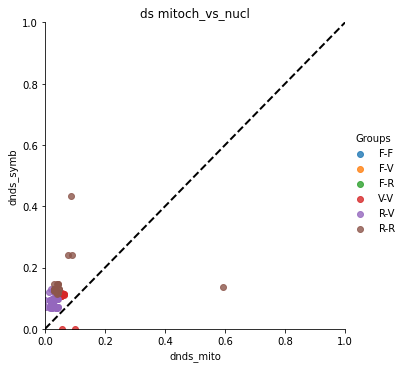

In [98]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(plt)
# Set figure size with matplotlib
# plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.lmplot(x='dnds_mito', y='dnds_symb',hue='Groups',fit_reg=False,data=dnds)

# add trend line
xmin,xmax=0,1
ymin,ymax=0,1
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('ds mitoch_vs_nucl')

Text(0.5, 1.0, 'ds mitoch_vs_nucl')

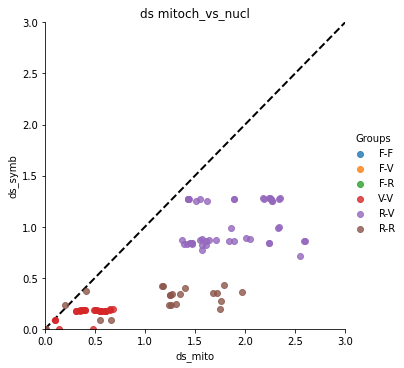

In [99]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(plt)
# Set figure size with matplotlib
# plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.lmplot(x='ds_mito', y='ds_symb',hue='Groups',fit_reg=False,data=dnds)

# add trend line
xmin,xmax=0,3
ymin,ymax=0,3
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('ds mitoch_vs_nucl')

Text(0.5, 1.0, 'mitoch dnds vs ds')

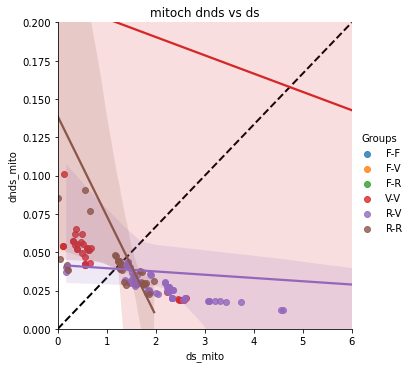

In [106]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(plt)
# Set figure size with matplotlib
# plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.lmplot(x='ds_mito', y='dnds_mito',hue='Groups',fit_reg=True,data=ml_dnds)

# add trend line
xmin,xmax=0,6
ymin,ymax=0,0.2
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('mitoch dnds vs ds')

Text(0.5, 1.0, 'symb dnds vs ds')

<Figure size 1000x600 with 0 Axes>

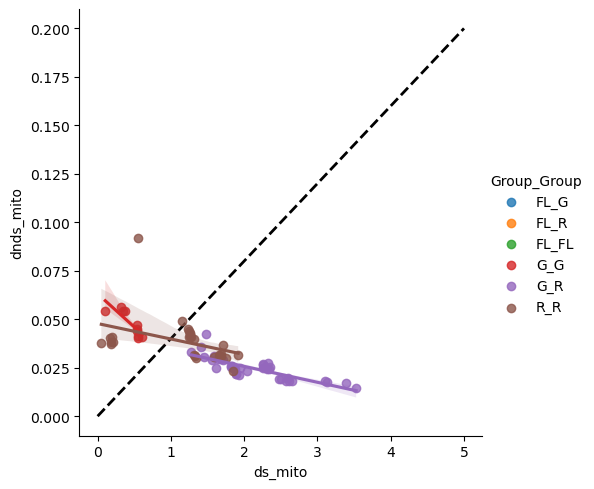

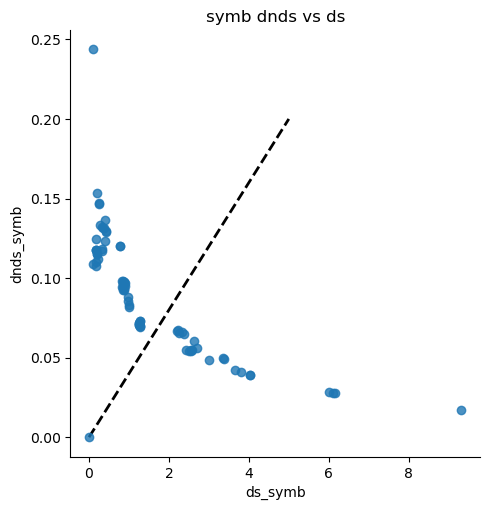

In [147]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(plt)
# Set figure size with matplotlib
plt.figure(figsize=(10,6))
# add trend line
xmin,xmax=0,5
ymin,ymax=0,0.2

# # Create scatter plot
sns.lmplot(x='ds_mito', y='dnds_mito',hue='Group_Group',fit_reg=True,data=ml_dnds)
plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)
sns.lmplot(x='ds_symb',y='dnds_symb',fit_reg=False,data=ml_dnds)



plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('symb dnds vs ds')

In [107]:
dnds[['ds_symb','dnds_symb','Groups']].dropna()

,ds_symb,dnds_symb,Groups
Bathy-SUP05,2.701645,0.055494,F-F
Bathy-diagonalis,6.088162,0.027825,F-V
Bathy-extenta,6.085860,0.027849,F-V
Bathy-fausta,2.288715,0.065575,F-R
Bathy-gigas1,5.747205,0.029509,F-V
...,...,...,...
rectimargo-soyoae1,0.839376,0.097216,R-V
rectimargo-soyoae2,0.839381,0.097104,R-V
southwardae-soyoae1,0.822741,0.094897,R-V
southwardae-soyoae2,0.822477,0.094809,R-V
